In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [6]:
train_dir = 'Face-Mask-Dataset/Train'
val_dir = 'Face-Mask-Dataset/Validation'
test_dir= 'Face-Mask-Dataset/Test'

In [16]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=20,
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

# Flow test images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [17]:
train_generator.class_indices

{'WithMask': 0, 'WithoutMask': 1}

In [18]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_shape=(224, 224, 3))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [19]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

In [20]:
model.summary()

[0][0]            
__________________________________________________________________________________________________
block_7_expand (Conv2D)         (None, 14, 14, 384)  24576       block_6_project_BN[0][0]         
__________________________________________________________________________________________________
block_7_expand_BN (BatchNormali (None, 14, 14, 384)  1536        block_7_expand[0][0]             
__________________________________________________________________________________________________
block_7_expand_relu (ReLU)      (None, 14, 14, 384)  0           block_7_expand_BN[0][0]          
__________________________________________________________________________________________________
block_7_depthwise (DepthwiseCon (None, 14, 14, 384)  3456        block_7_expand_relu[0][0]        
__________________________________________________________________________________________________
block_7_depthwise_BN (BatchNorm (None, 14, 14, 384)  1536        block_7_depthwise[0][0]  

In [21]:
H = model.fit(
	train_generator,
  steps_per_epoch=len(train_generator)/BS,
	validation_data=validation_generator,
  validation_steps = len(validation_generator)/BS,
	epochs=EPOCHS)

Epoch 1/20
15/15 [==============================] - 27s 1s/step - loss: 0.9169 - accuracy: 0.4913 - val_loss: 0.5300 - val_accuracy: 0.9250
Epoch 2/20
15/15 [==============================] - 19s 1s/step - loss: 0.7231 - accuracy: 0.5952 - val_loss: 0.4038 - val_accuracy: 0.9250
Epoch 3/20
15/15 [==============================] - 18s 1s/step - loss: 0.5387 - accuracy: 0.7956 - val_loss: 0.4377 - val_accuracy: 0.8750
Epoch 4/20
15/15 [==============================] - 17s 1s/step - loss: 0.4305 - accuracy: 0.8698 - val_loss: 0.3240 - val_accuracy: 0.9500
Epoch 5/20
15/15 [==============================] - 18s 1s/step - loss: 0.3835 - accuracy: 0.8766 - val_loss: 0.2527 - val_accuracy: 0.9500
Epoch 6/20
15/15 [==============================] - 21s 1s/step - loss: 0.3051 - accuracy: 0.9338 - val_loss: 0.2139 - val_accuracy: 0.9500
Epoch 7/20
15/15 [==============================] - 18s 1s/step - loss: 0.3592 - accuracy: 0.8769 - val_loss: 0.2191 - val_accuracy: 0.9500
Epoch 8/20
15/15 [==

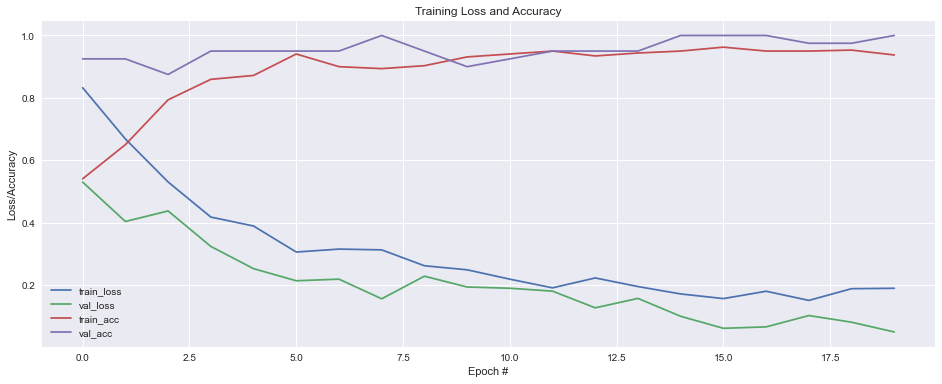

In [23]:
N = EPOCHS
plt.style.use("seaborn")
plt.figure(figsize=(16,6))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

In [24]:
model.evaluate(test_generator)

50/50 [==============================] - 46s 925ms/step - loss: 0.0933 - accuracy: 0.9788


[0.09334233403205872, 0.9788306355476379]

In [ ]:
model.save('mask_recog.h5')